# Xception con extracción de características

## Configuaración del entorno

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
original_dir = pathlib.Path("ExpandedDataset/")
new_base_dir = pathlib.Path("ExpandedDataset_organized/")
content = os.listdir(original_dir)
BATCH_SIZE = 64
size_x = 256
size_y = 256

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

## Importación y configuración del modelo Xception pre-entrenado

In [ ]:
xception_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(size_x , size_y, 3))

In [ ]:
xception_base.summary()

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.xception.preprocess_input(images)
        features = xception_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

In [ ]:
inputs = keras.Input(shape=(8, 8, 2048))
x = layers.Flatten()(inputs) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(58, activation="softmax")(x)
model5 = keras.Model(inputs, outputs)

model5.summary()

## Entreno y análisis

## Entreno y análisis

In [23]:
model5.compile(loss="categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="model5/best_version",
 save_best_only=True,
 monitor="val_loss")
]

history = model5.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
    batch_size=BATCH_SIZE)

Epoch 1/30
145/145 [==============================] - 3s 17ms/step - loss: 5.1581 - accuracy: 0.6298 - val_loss: 2.3497 - val_accuracy: 0.7612
INFO:tensorflow:Assets written to: model5\best_version\assets
Epoch 2/30
145/145 [==============================] - 2s 13ms/step - loss: 1.1462 - accuracy: 0.8700 - val_loss: 3.6350 - val_accuracy: 0.7457
Epoch 3/30
145/145 [==============================] - 2s 12ms/step - loss: 0.5940 - accuracy: 0.9300 - val_loss: 1.8079 - val_accuracy: 0.8328
INFO:tensorflow:Assets written to: model5\best_version\assets
Epoch 4/30
145/145 [==============================] - 2s 12ms/step - loss: 0.3800 - accuracy: 0.9527 - val_loss: 2.0957 - val_accuracy: 0.8595
Epoch 5/30
145/145 [==============================] - 2s 12ms/step - loss: 0.2446 - accuracy: 0.9695 - val_loss: 2.2206 - val_accuracy: 0.8517
Epoch 6/30
145/145 [==============================] - 2s 12ms/step - loss: 0.1657 - accuracy: 0.9783 - val_loss: 1.8142 - val_accuracy: 0.8534
Epoch 7/30
145/145

In [25]:
model5.save('model5/model')
np.save('model5/history.npy',history.history)

INFO:tensorflow:Assets written to: model5/model\assets


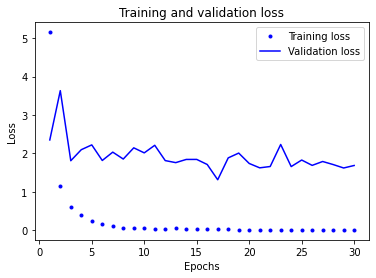

In [26]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "b.", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

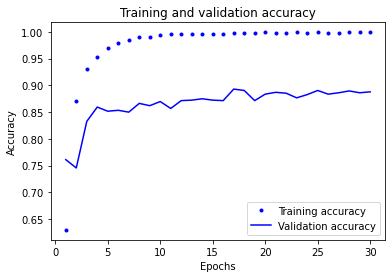

In [27]:
plt.clf()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, "b.", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
model = keras.models.load_model('model5/model')
results= model.evaluate(test_features, test_labels)
results

37/37 [==============================] - 0s 6ms/step - loss: 1.5087 - accuracy: 0.9026


[1.5087387561798096, 0.9025862216949463]

In [29]:
model = keras.models.load_model('model5/best_version')
results= model.evaluate(test_features, test_labels)
results

37/37 [==============================] - 0s 6ms/step - loss: 1.3592 - accuracy: 0.9129


[1.3592021465301514, 0.9129310250282288]